# Import NYC Dataset



In [1]:
import pandas as pd
import re


data_files = [
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/ap_2010.csv",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/class_size.csv",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/demographics.csv",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/graduation.csv",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/hs_directory.csv",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/sat_results.csv",
]
data = {}

for d in data_files:
    file = pd.read_csv(d)
    #get "name" without .csv
    name = d.rsplit('data/')[1]
    name = name.replace(".csv", "")
    data[name]=file
    
#survey files    
data_files = [
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/survey_all.txt",
"https://raw.githubusercontent.com/TomazFilgueira/Dq_Datascientist/refs/heads/main/3%20-%20Data_Cleaning/03_Data_Cleaning_Walktrough/data/survey_d75.txt",
]

all_survey = pd.read_csv(data_files[0],delimiter="\t",encoding="windows-1252")
d75_survey = pd.read_csv(data_files[1],delimiter="\t",encoding="windows-1252")    
    
survey = pd.concat([all_survey,d75_survey],axis=0)

survey = survey.copy()
survey['DBN'] = survey['dbn']

cols = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

#Filter survey so it only contains the columns we listed above
survey = survey[cols]

#Assign the dataframe survey to the key survey in the dictionary data.
data['survey'] = survey

#================================================================
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

#===============================================================
#if string is 2 digits long - return the string
#if string is less than 2 digits - fills with 0 in the front
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(lambda x: str(x).zfill(2))
data['class_size']['DBN'] =  data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

#convert to numeric data
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'],errors="coerce")

data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'],errors="coerce")

data['sat_results']['SAT Writing Avg. Score']= pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'],errors="coerce")

#sum up all the three columns
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']


#==============================================================
def get_lat(x):
    #extract raw coordinates
    y = re.findall("\(.+\)", x)
    
    #split lat and lon. remove '(' for latitude
    lat = y[0].split(',')[0].replace("(","")
    return lat

def find_lon(x):
    #extract raw coordinates
    y = re.findall("\(.+\)", x)
    
    #split lat and lon. remove ')' for longitude
    lon = y[0].split(',')[1].replace(")","").strip()
    return lon

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(get_lat)


#convert coordinates to numeric
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")




<>:67: SyntaxWarning: invalid escape sequence '\('
<>:75: SyntaxWarning: invalid escape sequence '\('
<>:67: SyntaxWarning: invalid escape sequence '\('
<>:75: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_514/3450759038.py:67: SyntaxWarning: invalid escape sequence '\('
  y = re.findall("\(.+\)", x)
/tmp/ipykernel_514/3450759038.py:75: SyntaxWarning: invalid escape sequence '\('
  y = re.findall("\(.+\)", x)


# 1) Introduction

In this lesson, we'll clean the NYC data more, then combine it. Finally, we'll compute correlations and perform some analysis.

The first thing we'll need to do in preparation for the merge is condense some of the datasets. In the last lesson, we noticed that the values in the `DBN` column were unique in the `sat_results` data set. Other data sets like `class_size` had duplicate `DBN` values.

While the main dataset we want to analyze, sat_results, has unique `DBN` values for every high school in New York City, other datasets aren't as clean. A single row in the `sat_results` dataset may match multiple rows in the `class_size` dataset, for example. This situation creates problems, because we don't know which of the multiple entries in the `class_size` dataset we should combine with the single matching entry in `sat_results`. Here's a diagram that illustrates the problem:

![alt text](image-1.png)

In the diagram above, we can't combine the rows from both datasets, because there are several cases where multiple rows in `class_size` match a single row in `sat_results`.

To resolve this issue, we'll condense the `class_size`, graduation and demographics datasets so that each `DBN` is unique.

# 2 3) Condensing the Class Size Dataset

The first dataset that we'll condense is `class_size`. The first few rows of class_size look like this:

In [2]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As you can see, the first few rows all pertain to the same school, which is why the `DBN` appears more than once. It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`.

If we look at the unique values for `GRADE`, we get the following:

```
array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)
```

Since we're dealing with high schools, we're only concerned with grades `9 through 12`. That means we only want to pick rows where the value in the `GRADE` column is `09-12`.

If we look at the unique values for `PROGRAM TYPE`, we get the following:

```
array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)
```

Each school can have multiple program types. Since `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` = `GEN ED`.


# 3) Instructions

1. Create a new variable called `class_size` and assign the value of `data["class_size"]` to it.

1. Filter `class_size` so the `GRADE ` column only contains the value `09-12`. Note that the name of the `GRADE` column has a space at the end; you'll generate an error if you don't include it.

1. Filter `class_size` so that the `PROGRAM TYPE` column only contains the value `GEN ED`.

1. Display the first five rows of `class_size` to verify.

In [3]:
class_size = data["class_size"]

#Filter class_size so the GRADE = 09-12
#Filter class_size so that the PROGRAM = GEN ED
class_size = class_size[ (class_size["GRADE "]=="09-12") & (class_size["PROGRAM TYPE"]=="GEN ED")]

class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


# 4 - 5) Computing Average Class Sizes

As we saw when we displayed `class_size` on the last exercise, `DBN` still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns.

`CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` seem to pertain to different kinds of classes. For example, here are the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

```
array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)
```

This column only seems to include **certain subjects**. We want our class size data to **include every single class a school offers** -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique DBN values, while also incorporating as much data as possible into the average.

Fortunately, we can use the `pandas.DataFrame.groupby()` method to help us with this. The DataFrame.`groupby()` method splits a dataframe up into unique groups, based on a given column. We can then use the `agg()` method on the resulting pandas.core.groupby object to find the **mean** of each column.

Using the `groupby()` method, we'll split this dataframe into four separate groups -- one with the `DBN 01M292`, one with the `DBN 01M332`, one with the `DBN 01M378`, and one with the `DBN 01M448`:

![alt text](image-2.png)

![alt text](image-3.png)

Then, we can compute the averages for the `AVERAGE CLASS SIZE` column in each of the four groups using the `agg()` method:

![alt text](image-4.png)

After we group a dataframe and aggregate data based on it, the column we performed the grouping on (in this case `DBN`) **becomes the index** and no longer appears as a column in the data itself. To undo this change and keep DBN as a column, we'll need to use `pandas.DataFrame.reset_index()`. This method **resets the index** to a list of integers and make DBN a column again.

In [4]:
class_size = class_size.groupby("DBN").agg('mean',numeric_only=True)
class_size.reset_index(inplace=True)

data['class_size']=class_size

data['class_size']

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1.0,88.000000,4.000000,22.564286,18.500000,26.571429,NaN
1,01M332,1.0,46.000000,2.000000,22.000000,21.000000,23.500000,NaN
2,01M378,1.0,33.000000,1.000000,33.000000,33.000000,33.000000,NaN
3,01M448,1.0,105.687500,4.750000,22.231250,18.250000,27.062500,NaN
4,01M450,1.0,57.600000,2.733333,21.200000,19.400000,22.866667,NaN
...,...,...,...,...,...,...,...,...
578,32K549,32.0,71.066667,3.266667,22.760000,19.866667,25.866667,NaN
579,32K552,32.0,102.375000,4.312500,23.900000,19.937500,28.000000,NaN
580,32K554,32.0,66.937500,3.812500,17.793750,14.750000,21.625000,NaN
581,32K556,32.0,132.333333,5.400000,25.060000,18.333333,30.000000,NaN


# 6-7) Condensing the Demographics Dataset

Now that we've finished condensing `class_size`, let's condense `demographics` dataset.

In this case, the only column that prevents a given `DBN` from being **unique** is `schoolyear`. We only want to select rows where `schoolyear` = `20112012`. This will give us the most recent year of data, and also match our SAT results data.


In [5]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


## Instructions

1. Filter demographics, only selecting rows in data["demographics"] where schoolyear is 20112012.
    * schoolyear is actually an **integer**, so be careful about how you perform your comparison.

1. Display the first five rows of data["demographics"] to verify that the filtering worked.

In [6]:
data['demographics'] =data['demographics'][data['demographics']['schoolyear']==20112012]

data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


# 8-9 Condensing the Graduation Dataset

Finally, we'll need to condense the `graduation` dataset. Here are the first few rows:

In [7]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the `graduation` data. A Cohort appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll **only pick rows where Demographic is Total Cohort**.

## Instructions

1. Filter `graduation`, only select rows where the `Cohort` column equals 2006.
1. Filter `graduation`, only select rows where the `Demographic` column equals Total Cohort.
1. Display the first few rows of data["graduation"] to verify that everything worked properly.

In [8]:
data['graduation'] = data['graduation'][(data['graduation']['Cohort']=="2006") & (data['graduation']['Demographic']=='Total Cohort')]

data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


# 10)  Converting AP Test Scores

The last thing to do is convert the `Advanced Placement (AP)` test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.


AP exams have a `1` to `5` scale; `3` or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the `ap_2010` data set **to numeric values** first.

There are three columns we'll need to convert:

1. `AP Test Takers `(note that there's a trailing space in the column name)

1.`Total Exams Taken`

1. `Number of Exams with scores 3 4 or 5`

## Instructions

1. Convert each of the following columns in `ap_2010` to numeric values using the `pandas.to_numeric()` function with the keyword argument `errors="coerce"`.

    * `AP Test Takers`
    * `Total Exams Taken`
    * `Number of Exams with scores 3 4 or 5`

1. Display the column types using the dtypes attribute.

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010']  [c],errors="coerce")

print(data['ap_2010'].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


# 11 - 12) Left, Right, Inner, and Outer Joins

Before we merge our data, we'll need to decide on the merge strategy we want to use. We'll be using the pandas `pandas.DataFrame.merge()` function, which supports four types of joins -- `left`, `right`, `inner`, and `outer`. Each of these join types dictates how pandas combines the rows.

We'll be using the `DBN` column to identify matching rows across datasets.
There may be `DBN` values that exist in one dataset but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered. Human error (and other types of errors) may also play a role. Therefore, we may not find matches for the `DBN` values in `sat_results` in all of the other datasets and other datasets may have `DBN` values that don't exist in `sat_results`.

We'll merge **two datasets at a time**. For example, we'll merge `sat_results` and `hs_directory`, then merge the result with `ap_2010`, then merge the result of that with class_size. We'll continue combining datasets in this way until we've merged all of them. Afterwards, we'll have roughly the same number of rows, but each row has columns from all of the datasets.

The merge strategy we pick affects the number of rows we end up with. Let's take a look at each strategy.

With an **inner merge**, we'd only combine rows where the same `DBN` exists in both datasets. We'd end up with this result:

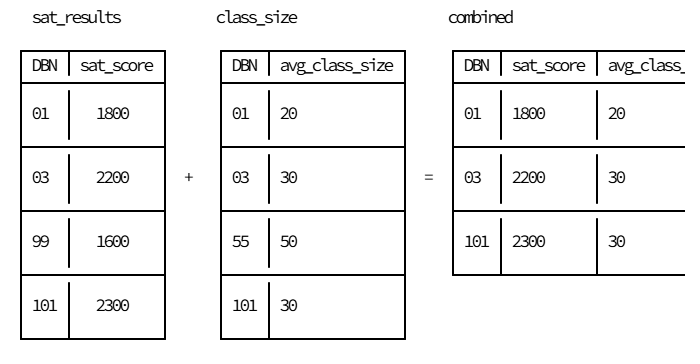

With a **left merge**, we'd only use `DBN` values from the dataframe on the "left" of the merge. In this case, `sat_results` is on the left. Some of the DBNs in `sat_results` don't exist in `class_size`, though. 

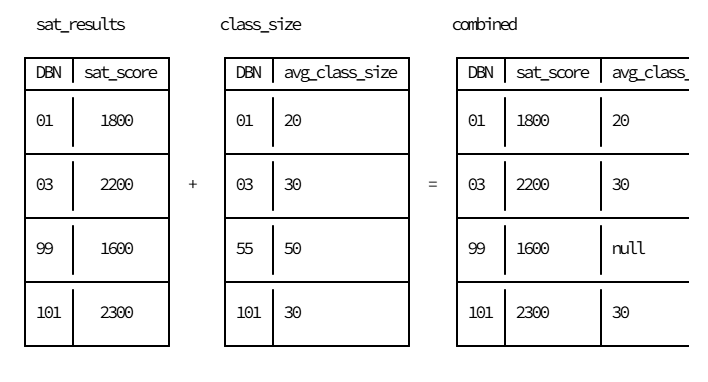

With a **right merge**, we'll only use `DBN` values from the dataframe on the "right" of the merge. In this case, `class_size` is on the right:

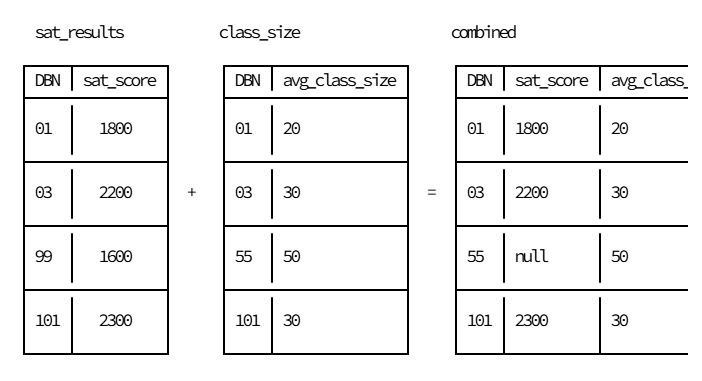


With an **outer merge**, we'll take any `DBN` values from either `sat_results` or `class_size`:

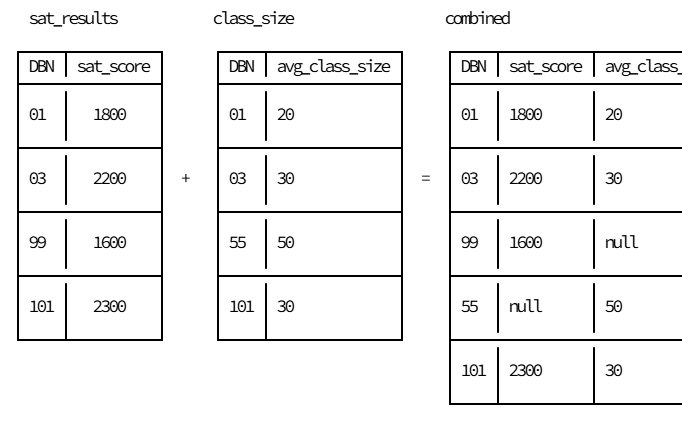

As you can see, each merge strategy has its advantages. Depending on the strategy we choose, we may preserve rows at the expense of having more missing column data or minimize missing data at the expense of having fewer rows.

Since this project is concerned with determining demographic factors that correlate with **SAT score**, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

This means that we may need to use **different merge strategies** with different datasets. Some of the datasets have a lot of missing `DBN` values. This makes a **left join** more appropriate, because we don't want to lose too many rows when we merge. If we did an inner join, we would lose the data for many high schools.

Some datasets have `DBN` values that are almost identical to those in `sat_results`. Those datasets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from `demographics`, for example. Therefore, we'll do an **inner join** to avoid missing data in these columns.


# 12 Performing the Left Joins

Both the `ap_2010` and the graduation datasets have many missing `DBN` values, so we'll use a `left` join when we merge the `sat_results` data set with them. Since we're using a `left` join, our final dataframe will have all of the same `DBN` values as the original `sat_results` dataframe.

We'll need to use the pandas `df.merge()` method to merge dataframes. The "**left**" dataframe is the one we call the method on, and the "**right**" dataframe is the one we pass into `df.merge()`.

Because we're using the `DBN` column to join the dataframes, we'll need to specify the keyword argument `on="DBN"` when calling `pandas.DataFrame.merge()`.

First, we'll assign `data["sat_results"]` to the variable `combined`. Then, we'll merge the other dataframes with combined. When we're finished, `combined` has columns from **all of the datasets**.


## Instructions

1. Use the pandas `pandas.DataFrame.merge()` method to merge the `ap_2010` dataset into `combined`.
    * Make sure to specify `how="left"` as a keyword argument to indicate the correct join type.
    * Make sure to assign the result of the merge operation back to `combined`.

1. Use the pandas `df.merge()` method to merge the `graduation` dataset into combined.
    * Make sure to specify `how="left"` as a keyword argument to get the correct join type.
    * Make sure to assign the result of the merge operation back to `combined`.

1. Display the first few rows of combined to verify that the correct operations occurred.

1. Use the `pandas.DataFrame.shape` attribute to display the shape of the dataframe and see how many rows now exist.



In [10]:
combined = data["sat_results"]

#merge with ap_2010
combined = combined.merge(data["ap_2010"],how="left",on="DBN")

#merge with "graduation"
combined = combined.merge(data["graduation"],how="left",on="DBN")

print(combined.head())
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

# 13) Performing the Inner Joins

Now that we've performed the `left` joins, we still have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Since these files contain information that's more valuable to our analysis and also have fewer missing `DBN` values, we'll use the **inner join type**.

## Instructions

1. Merge `class_size` into `combined`. Then, merge `demographics`, `survey`, and `hs_directory` into combined one by one, in that order.
    * Be sure to follow the exact order above.
    * Remember to specify the correct column to join on, as well as the correct join type.

1.  Display the first few rows of `combined` to verify that the correct operations occurred.

1. Use the pandas.DataFrame.shape attribute to display the shape of the dataframe to see how many rows now exist.

In [11]:
#merge with class_size
combined = combined.merge(data["class_size"],how="inner",on="DBN")

#merge with demographics
combined = combined.merge(data["demographics"],how="inner",on="DBN")

#merge with survey
combined = combined.merge(data["survey"],how="inner",on="DBN")

#merge with hs_directory
combined = combined.merge(data["hs_directory"],how="inner",on="DBN")

print(combined.head())
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

# 14 - 15) Filling in Missing Values

You may have noticed that the inner joins resulted in **116 fewer rows** in `sat_results`. This is because pandas couldn't find the `DBN` values that existed in `sat_results` in the other datasets.

You may also have noticed that we now have many columns with null (`NaN`) values. This is because we chose to do `left` joins, where some columns may not have had data.

There are several ways to handle missing data and we'll cover them in more detail later on. For now, we'll just **fill in the missing values with the overall mean** for the column, like so:

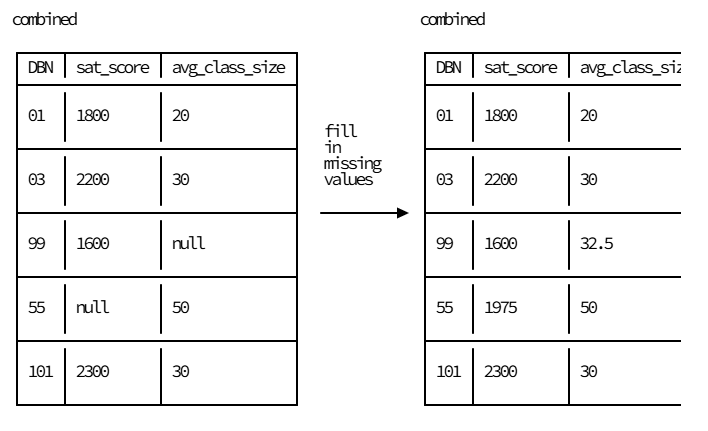

In the diagram above, the mean of the first column is `(1800 + 1600 + 2200 + 2300) / 4`, or **1975**, and the mean of the second column is `(20 + 30 + 30 + 50) / 4`, or **32.5**. We replace the missing values with the ^^ of their respective columns, which allows us to proceed with analyses that can't handle missing values (like correlations).

We can fill in missing data in pandas using the `pandas.DataFrame.fillna()` method. This method replaces any missing values in a dataframe with the values we specify. We can compute the **mean** of every column using the `pandas.DataFrame.mean()` method. If we pass the results of the `df.mean()` method into the `df.fillna()` method, pandas fills in the missing values in each column with the mean of that column.

```
means = df.mean()
df = df.fillna(means)

```

In this case, since the means are calculated on **numeric columns**, there’s no need to worry about the data types of non-numeric columns. However, if there are columns with mixed or object types, filling missing values with `0` could lead to unexpected results or incorrect data types.

To address this, we use the `pandas.DataFrame.infer_objects()` method. This method ensures that object-type columns in `combined` are converted to their appropriate inferred data types before filling the missing values with 0. We also use the `copy=False `parameter to avoid creating an unnecessary copy of the data.

After inferring the correct data types, we fill any remaining `NaN` or null values with `0`:


```
df = df.infer_objects(copy=False).fillna(0)
```


## Instructions

1. Calculate the means of all of the columns in combined using the `pandas.DataFrame.mean()` method.
    * Use the `numeric_only` parameter to ensure the calculations are only performed on **numeric columns**.

1. Fill in any missing values in combined with the means of the respective columns using the pandas.`DataFrame.fillna()` method.

1. Fill in any remaining missing values in combined with 0 using the `df.fillna()` method.

1. Display the first few rows of combined to verify that the correct operations occurred.

In [ ]:
#fill NAN with mean for each column
mean = combined.mean(numeric_only=True)
combined.fillna(mean)

#fill remaining NAN with 0
combined = combined.infer_objects(copy=False).fillna(0)

print(combined.head())